In [54]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import os
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [55]:
dirpath = os.getcwd()

df1 = pd.read_csv(dirpath + '\\ames_housing_trimmed_processed.csv')

In [56]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 57 columns):
MSSubClass              1460 non-null int64
LotFrontage             1460 non-null float64
LotArea                 1460 non-null int64
OverallQual             1460 non-null int64
OverallCond             1460 non-null int64
YearBuilt               1460 non-null int64
Remodeled               1460 non-null int64
GrLivArea               1460 non-null int64
BsmtFullBath            1460 non-null int64
BsmtHalfBath            1460 non-null int64
FullBath                1460 non-null int64
HalfBath                1460 non-null int64
BedroomAbvGr            1460 non-null int64
Fireplaces              1460 non-null int64
GarageArea              1460 non-null int64
MSZoning_FV             1460 non-null int64
MSZoning_RH             1460 non-null int64
MSZoning_RL             1460 non-null int64
MSZoning_RM             1460 non-null int64
Neighborhood_Blueste    1460 non-null int64
Neighborhoo

In [57]:
#drop outliers
df1 = df1.drop(df1[(df1['GrLivArea']>4000) & (df1['SalePrice']<300000)].index);
df1 = df1.drop(df1[(df1['SalePrice']>600000)].index);

#needed for linear prediction
df1["SalePrice"] = np.log1p(df1["SalePrice"])

In [58]:
X, y = df1.iloc[:,:-1], df1.iloc[:,-1]

[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[07:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth

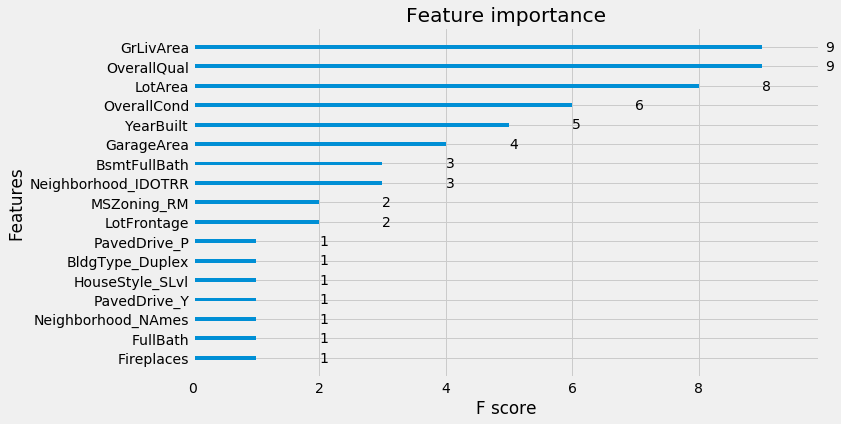

In [59]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

plt.rcParams['figure.figsize'] = [10, 6]

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

In [60]:
features = ['GrLivArea','LotArea','YearBuilt','OverallQual']
df1 = df1[['GrLivArea','LotArea','YearBuilt','OverallQual','SalePrice']]
df1.describe()

,GrLivArea,LotArea,YearBuilt,OverallQual,SalePrice
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000
mean,1504.453920,10429.677442,1971.143054,6.083906,12.020144
std,493.518359,9844.948459,30.199591,1.364621,0.393342
min,334.000000,1300.000000,1872.000000,1.000000,10.460271
25%,1128.000000,7536.250000,1954.000000,5.000000,11.774528
50%,1458.000000,9458.500000,1972.000000,6.000000,12.001205
75%,1774.000000,11546.250000,2000.000000,7.000000,12.271397
max,3608.000000,215245.000000,2010.000000,10.000000,13.275829


In [61]:
X, y = df1.iloc[:,:-1], df1.iloc[:,-1]

# split data into train and test portions and model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # loop through each feature and calculate the R^2 score
for feat in features:
    model_lr = linear_model.LinearRegression()
    model_lr.fit(X_train[[feat]], y_train)
    predictions = model_lr.predict(X_test[[feat]])
    print('R^2 for %s is %f' % (feat, r2_score(y_test, predictions)))

R^2 for GrLivArea is 0.501466
R^2 for LotArea is 0.068708
R^2 for YearBuilt is 0.331026
R^2 for OverallQual is 0.671310


In [62]:
# train the model on training set
model_lr.fit(X_train, y_train)

# make predictions using the testing set
predictions = model_lr.predict(X_test)
 
# root mean squared error
print("Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_test, predictions)))
print('\n')
print('Intercept: %f' % model_lr.intercept_)

# features with coefficients 
feature_coefficients  = pd.DataFrame({'coefficients':model_lr.coef_, 
                                    'features':X_train.columns.values})

feature_coefficients.sort_values('coefficients')

Root Mean squared error: 0.17


Intercept: 3.702352


,coefficients,features
1,0.000004,LotArea
0,0.000315,GrLivArea
2,0.003580,YearBuilt
3,0.121906,OverallQual


In [63]:
from sklearn.ensemble import GradientBoostingRegressor
model_gbr = GradientBoostingRegressor() 
model_gbr.fit( X_train, np.ravel( y_train)) 
predictions = model_gbr.predict( X_test) 
print("Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_test, predictions)))

Root Mean squared error: 0.16


Text(0.5,1,'Evaluation of Predictions XGBoost')

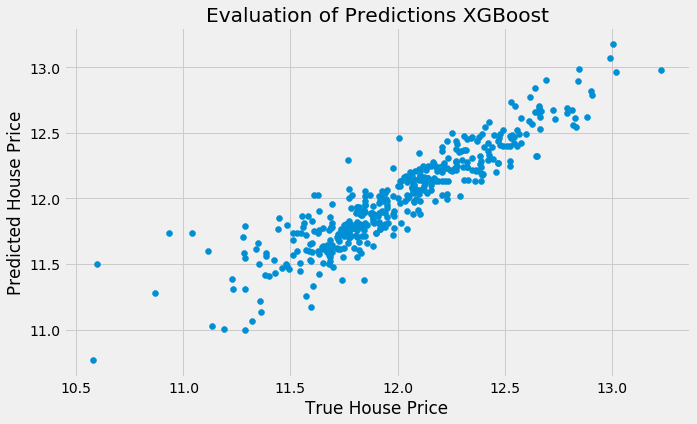

In [64]:
# let's evaluate our predictions respect to the original price
plt.scatter(y_test, model_gbr.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Predictions XGBoost')

Text(0.5,1,'Evaluation of Predictions Linear prediction')

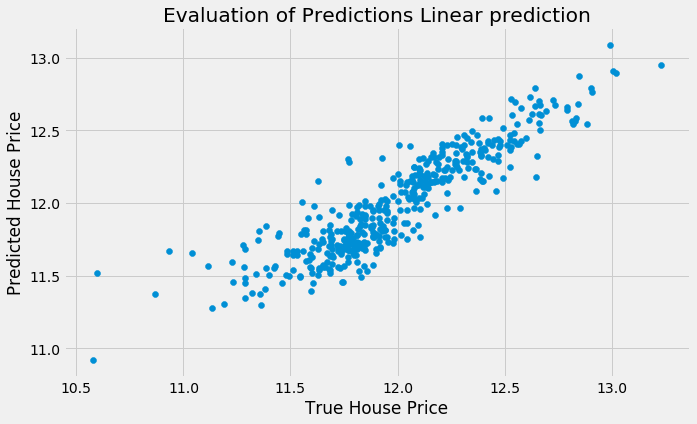

In [65]:
# let's evaluate our predictions respect to the original price
plt.scatter(y_test, model_lr.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Predictions Linear prediction')

In [66]:
pred = model_lr.predict(X_train)
print('linear train mse: {}'.format(mean_squared_error(np.exp(y_train), np.exp(pred))))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(np.exp(y_train), np.exp(pred)))))
print()
pred = model_lr.predict(X_test)
print('linear test mse: {}'.format(mean_squared_error(np.exp(y_test), np.exp(pred))))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))))
print()
print('Average house price: ', np.exp(y_train).median())

linear train mse: 964923653.7697026
linear train rmse: 31063.220273656472

linear test mse: 825139677.163278
linear test rmse: 28725.244597100962

Average house price:  164990.99999999988


In [67]:
# set up constants for our coefficients 
INTERCEPT = 3.702352
COEF_LOT = 0.000004    
COEF_LIV = 0.000315       
COEF_YR = 0.003580    
COEF_QUAL = 0.121906  

MEAN_LOT_AREA = 10429  
MEAN_GR_LIV_AREA = 1504       
MEAN_YR_BUILT = 1971    
MEAN_OVERALL_QUAL = 6.1  

In [68]:
# prediction
house_price = INTERCEPT + (COEF_LOT * MEAN_LOT_AREA) \
    + (COEF_LIV * MEAN_GR_LIV_AREA)  + (COEF_YR * MEAN_YR_BUILT) \
    + (COEF_QUAL * MEAN_OVERALL_QUAL)  

#use the mean values for default 
print('Estimated house price for selected parameters:$%i' % int(np.exp(house_price)))

Estimated house price for selected parameters:$165650


In [69]:
np.exp(df1.SalePrice.mean())

166066.53032458163

In [70]:
#put the features into categories for app
df1.describe()

,GrLivArea,LotArea,YearBuilt,OverallQual,SalePrice
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000
mean,1504.453920,10429.677442,1971.143054,6.083906,12.020144
std,493.518359,9844.948459,30.199591,1.364621,0.393342
min,334.000000,1300.000000,1872.000000,1.000000,10.460271
25%,1128.000000,7536.250000,1954.000000,5.000000,11.774528
50%,1458.000000,9458.500000,1972.000000,6.000000,12.001205
75%,1774.000000,11546.250000,2000.000000,7.000000,12.271397
max,3608.000000,215245.000000,2010.000000,10.000000,13.275829
